In [1]:
import time
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, './CFE')
import bmi_cfe

print(bmi_cfe)


<module 'bmi_cfe' from 'C:\\Users\\zjbut\\Documents\\GitHub\\NextGen---The-Simulators-\\Toy_Model\\./CFE\\bmi_cfe.py'>


In [2]:
cfe_instance = bmi_cfe.BMI_CFE() #one that changes state vars
print("CFE")
print(cfe_instance.get_input_var_names())
print()
print(cfe_instance.get_output_var_names())


CFE
['atmosphere_water__time_integral_of_precipitation_mass_flux', 'water_potential_evaporation_flux', 'state_var_change']

['land_surface_water__runoff_depth', 'land_surface_water__runoff_volume_flux', 'DIRECT_RUNOFF', 'GIUH_RUNOFF', 'NASH_LATERAL_RUNOFF', 'DEEP_GW_TO_CHANNEL_FLUX']


### This initialization function should perform all tasks that are to take place before entering the model’s time loop. Models should be refactored, if necessary, to read their inputs (which could include filenames for other input files) from a configuration file. BMI does not impose any constraint on how configuration files are formatted.

In [3]:
cfe_instance.initialize(cfg_file='./CFE/cat_58_config_cfe.json')
cfe_instance.forcing_file # path to forcing file


'./Forcing/cat58_01Dec2015.csv'

### Open the forcing file contained within the configuration file. We can run the model with any forcing. This is only an example. The path to the forcing file is contained within the configuration file, but it doesn't really need to be. This is just for organization.

In [4]:
with open(cfe_instance.forcing_file, 'r') as f:
    df_forcing = pd.read_csv(f)
    
print(df_forcing)

                    time  APCP_surface  DLWRF_surface  DSWRF_surface  \
0    2015-12-01 00:00:00           0.0     361.200012       0.000000   
1    2015-12-01 01:00:00           0.0     361.200012       0.000000   
2    2015-12-01 02:00:00           0.0     361.200012       0.000000   
3    2015-12-01 03:00:00           0.0     357.600006       0.000000   
4    2015-12-01 04:00:00           0.0     357.600006       0.000000   
..                   ...           ...            ...            ...   
715  2015-12-30 19:00:00           4.7     402.200012     163.600006   
716  2015-12-30 20:00:00           3.7     402.200012     130.300003   
717  2015-12-30 21:00:00           4.2     399.200012      80.400002   
718  2015-12-30 22:00:00           8.3     399.200012      21.000000   
719  2015-12-30 23:00:00           3.3     399.200012       0.000000   

     PRES_surface  SPFH_2maboveground  TMP_2maboveground  UGRD_10maboveground  \
0        100530.0              0.0105         287.5000

### We will want to visualize the model output

In [5]:
# Originial CFE Model
cfe_outputs=cfe_instance.get_output_var_names()
cfe_output_lists = {output:[] for output in cfe_outputs}

print(cfe_output_lists)


{'land_surface_water__runoff_depth': [], 'land_surface_water__runoff_volume_flux': [], 'DIRECT_RUNOFF': [], 'GIUH_RUNOFF': [], 'NASH_LATERAL_RUNOFF': [], 'DEEP_GW_TO_CHANNEL_FLUX': []}


### Now we loop through the forcing data and use it to run the model at each time step

In [6]:
########################################
# Loop through all of forcing data; model and peturbed

    # Keep track of time
    
    # Set forcing data for model
    # Set forcing for peturbed models. Aren't they using the same forcing data?
    
    # Update model
    
    # Update observation data
    
    # Update ensemble of peturbed models 
        
    # Update DA   
    
    # Get value of DA and set value to model
    
    # Set value of streamflow. Depending on this, we will change state variables below
        # soil_reservoir_storage_deficit_m (25) 
        # Covary the runoff_queue_m_per_timestep (197)
        # Schaake_output_runoff_m (310-3018), least important to start
        
    # if DA streamflow value is greater than the mean of #cfs, then 197 should be lowered by #% based on range of %changes
        # #% is based on range of %changes
        # Else, 197 should be raised by #% based on range of %changes
        # Set value of state_var_change that corresponds to DA streamflow based on %change table 
        
    # if DA streamflow value is greater than the mean of #cfs, then 25 should be lowered by #% 
        # #% is based on range of %changes
        # Else, 23 should be raised by #% based on range of %changes    
        

In [7]:
import numpy as np

cfe = []
cfe_sum = []

percent_list = np.arange(0.1,2.0,0.05)
percentList = percent_list.tolist()

for percent in percent_list:
    
    cfe_instance.set_value('state_var_change', percent) #value of precip from forcing data in loop
    
    for i, precip in enumerate(df_forcing['APCP_surface']): #i is 

        framework_time = (1+i)*3600 #seconds since starting simulation

        # Run CFE model
        cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
        cfe_instance.update()
        outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe_sum.append(np.sum(outflow))

df = pd.DataFrame({'Percentage':percentList,'Sum_streamflow':cfe_sum})
df



,Percentage,Sum_streamflow
0,0.10,3.140547
1,0.15,4.711567
2,0.20,6.282348
3,0.25,7.853020
4,0.30,9.423650
5,0.35,10.994266
6,0.40,12.564878
7,0.45,14.135489
8,0.50,15.706099
9,0.55,17.276709


In [12]:
# Find mean streamflow to based changes on
# df_mean = df['Sum_streamflow'].mean()
#print('The Mean streamflow is %s' %(df_mean))

# If statement to add group to assocaited percent range 
df.loc[df['Percentage'] <=0.25,'Group'] = 1
df.loc[(df['Percentage'] > 0.25) & (df['Percentage'] <= 0.5),'Group'] = 2
df.loc[(df['Percentage'] > 0.5) & (df['Percentage'] <= 1.0),'Group'] = 3
df.loc[(df['Percentage'] > 1.0) & (df['Percentage'] <= 1.5),'Group'] = 4
df.loc[(df['Percentage'] > 1.5) & (df['Percentage'] <= 2.0),'Group'] = 5

# Test runoff
runoff_queue_m_per_timestep = 1
df.loc[(df['Group'] == 3), 'runoff_queue_m_per_timestep'] = runoff_queue_m_per_timestep * 0.1
print(df)

    Percentage  Sum_streamflow  Group  runoff_queue_m_per_timestep
0         0.10        3.140547    1.0                          NaN
1         0.15        4.711567    1.0                          NaN
2         0.20        6.282348    1.0                          NaN
3         0.25        7.853020    2.0                          NaN
4         0.30        9.423650    2.0                          NaN
5         0.35       10.994266    2.0                          NaN
6         0.40       12.564878    2.0                          NaN
7         0.45       14.135489    2.0                          NaN
8         0.50       15.706099    3.0                          0.1
9         0.55       17.276709    3.0                          0.1
10        0.60       18.847318    3.0                          0.1
11        0.65       20.417928    3.0                          0.1
12        0.70       21.988538    3.0                          0.1
13        0.75       23.559148    3.0                         

In [20]:
# Set up example data assimilated streamflow value to then represent %change in flow 
DA_sum = 9.423650     #output from DA

if DA_sum <=  df['Sum_streamflow']:
    runoff_queue_m_per_timestep = df['Percentage']
    print(runoff_queue_m_per_timestep)


ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

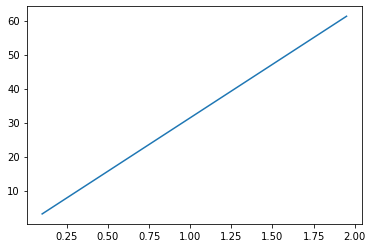

In [10]:
x = df.iloc[:,0]
y = df.iloc[:,1]
plt.plot(x, y)

In [11]:
# Make empty matrices for plotting
# sim = []
# obs = []
# assimilation = []
cfe = []
cfe_sum = []

# Run USG model
# USGS_instance.update()
# obs = USGS_instance.get_value('Flow')
#print(obs)

for i, precip in enumerate(df_forcing['APCP_surface']): #i is 
    
    framework_time = (1+i)*3600 #seconds since starting simulation
    
    # Run CFE model
    cfe_instance.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
    cfe_instance.update()
    outflow = cfe_instance.get_value('land_surface_water__runoff_depth')
    cfe.append(outflow)
    
#     # Peturbation run   
#     cfe_instance_peturb.set_value('atmosphere_water__time_integral_of_precipitation_mass_flux', precip) #value of precip from forcing data in loop
#     cfe_instance_peturb.update()
#     outflow_peturb = cfe_instance_peturb.get_value('land_surface_water__runoff_depth_ens')
    
    # Calculate states of ensemble runs
#     outflow_peturb_mean = np.mean(outflow_peturb)
#     outflow_peturb_std = np.std(outflow_peturb)
#     outflow_peturb_var = np.var(outflow_peturb)
#     outflow_peturb_covar = np.cov(outflow_peturb)
    outflow_sum = np.sum(outflow)
    cfe_sum.append(outflow_sum)


    
#     #obs.append(outflow_peturb_std)
#     sim.append(outflow_peturb_mean)
    
#     # Assimilation
#     cfe_assimilation.set_value('obs', obs[i]*10) #need these to represent pdf of flows
#     cfe_assimilation.set_value('sim', outflow_peturb_mean)
#     cfe_assimilation.update()
    
#     # Make matrix to put assimilation output
#     output = np.zeros(1)
#     DA_output = cfe_assimilation.get_value('assimilation', output)
#     #print(DA_output)
#     assimilation.append(DA_output) #append empty matrix to output for plotting
    
# print('The covarince is', outflow_peturb_covar)
# print('The mean is ', outflow_peturb_mean)
# print('The std is ', outflow_peturb_std)

df = {'Percentage':,'Sum streamflow':}


SyntaxError: invalid syntax (Temp/ipykernel_5792/914535691.py, line 56)

In [ ]:
sum_peturb = np.sum(sim)
sum_cfe = np.sum(cfe)
percent_diff = ((sum_peturb - sum_cfe) / sum_peturb)
print('Percenter Difference', percent_diff * 100) #if postive, then decrease in flow

### The finalize function should perform all tasks that take place after exiting the model’s time loop. This typically includes deallocating memory, closing files and printing reports.

In [ ]:
cfe_instance.finalize(print_mass_balance=False)
cfe_instance_peturb.finalize(print_mass_balance=False)

### Here we are just plotting the fluxes.

In [ ]:
istart_plot=500
iend_plot=550
x = list(range(istart_plot, iend_plot))

fig = plt.figure(figsize = (7,5), dpi=300)

plt.plot(x, cfe[istart_plot:iend_plot], color = 'orange', label = 'CFE State Vars')

plt.title('Sub-Region Model DA Example')
plt.plot(x, sim[istart_plot:iend_plot], color = 'tab:blue', label = 'CFE Peturbed')
plt.plot(x, assimilation[istart_plot:iend_plot], color = 'green', label = 'DA')
plt.plot(x, obs[istart_plot:iend_plot]*10, color = 'tab:red', linestyle='dashed', label = 'USGS Obs')
plt.ylabel('Streamflow (CFS)')
plt.xlabel('Time')
plt.legend()


### Here we are just going to run the unit test that compares with the origional author code. Kind of the same thing done above, but there is a function in the BMI code that does it all at once.